In [25]:
from collections import Counter

import pandas as pd
import json

import seaborn
from matplotlib import pyplot as plt

seaborn.set_theme()

In [4]:
data = pd.read_csv('data/credits.csv')
data.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [6]:
import ast

# Parse `cast` and `crew` columns
data['cast_parsed'] = data['cast'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else None)
data['crew_parsed'] = data['crew'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else None)

# Filter out rows where parsing failed
valid_cast_data = data.dropna(subset=['cast_parsed'])
valid_crew_data = data.dropna(subset=['crew_parsed'])


In [7]:
# What are the total number of rows and columns in the dataset?
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

Number of rows: 45476
Number of columns: 5


In [8]:
# Are there any missing or null values in the dataset? If yes, which columns have missing values and how many?
missing_values = data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

Missing values in each column:
cast           0
crew           0
id             0
cast_parsed    0
crew_parsed    0
dtype: int64


In [9]:
# What are the data types of each column in the dataset? Are there any columns that need type conversions?
for col in data.columns:
    print(f"Data type of column {col}: {type(data[col][0])}")

Data type of column cast: <class 'str'>
Data type of column crew: <class 'str'>
Data type of column id: <class 'numpy.int64'>
Data type of column cast_parsed: <class 'list'>
Data type of column crew_parsed: <class 'list'>


In [10]:
# How many unique movies are there in the dataset based on the id column?
number_of_unique_movies = data['id'].nunique()
print(f"Number of unique movies in the dataset based on 'id' column: {number_of_unique_movies}")

Number of unique movies in the dataset based on 'id' column: 45432


In [16]:
# Extract the names of crew members from the crew column and find out the most common roles (like Director, Producer, etc.) in the dataset.

def extract_roles(crew_list):
    roles = []
    for crew_data in crew_list:
        if isinstance(crew_data, dict) and 'job' in crew_data:
            roles.append(crew_data['job'])
    return roles

crew_roles = valid_crew_data['crew_parsed'].dropna().apply(extract_roles).explode()
role_counts = Counter(crew_roles).most_common()
print("Most common roles in the crew:")
print(role_counts[:10])

Most common roles in the crew:
[('Director', 49048), ('Producer', 43555), ('Writer', 30431), ('Screenplay', 25163), ('Editor', 23800), ('Director of Photography', 20659), ('Executive Producer', 18866), ('Original Music Composer', 15790), ('Casting', 12635), ('Art Direction', 11689)]


In [20]:
# From the cast column, which actors appear most frequently in the dataset?
def extract_actors(cast_list):
    actors = [] 
    for cast_data in cast_list:
        if isinstance(cast_data, dict) and 'name' in cast_data:
            actors.append(cast_data['name'])
    return actors

actor_names = valid_cast_data['cast_parsed'].dropna().apply(extract_actors).explode()
actor_counts = Counter(actor_names).most_common()
print("Most frequently appearing actors:")
print(actor_counts[1:11]) # The most popular "actor" in the dataset is "nan"

Most frequently appearing actors:
[('Bess Flowers', 241), ('Christopher Lee', 148), ('John Wayne', 125), ('Samuel L. Jackson', 123), ('Gérard Depardieu', 110), ('Michael Caine', 110), ('Donald Sutherland', 109), ('John Carradine', 109), ('Jackie Chan', 108), ('Frank Welker', 107)]


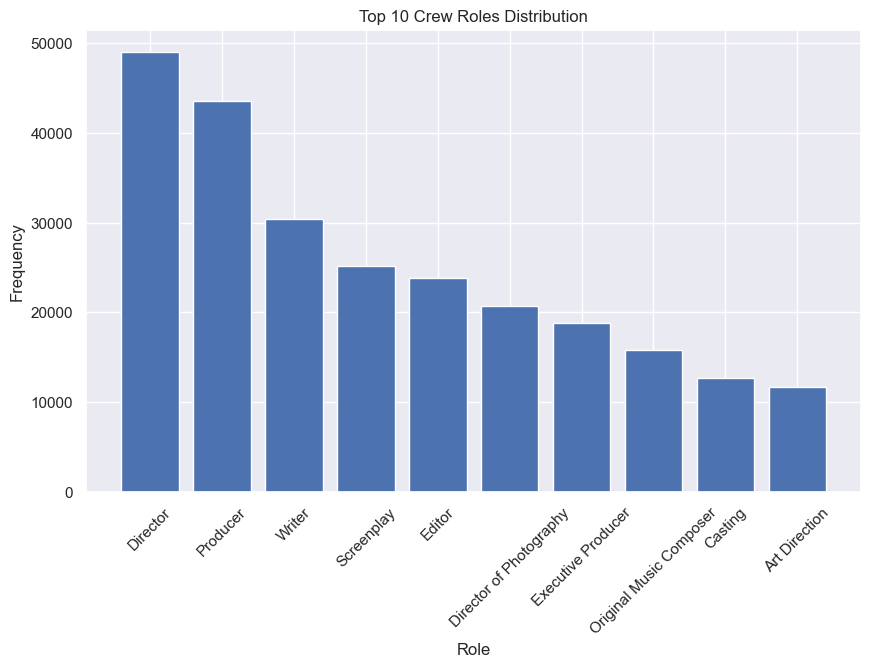

In [26]:
# Create a bar chart to visualize the distribution of different crew roles (Director, Producer, etc.).
top_roles = dict(role_counts[:10])
plt.figure(figsize=(10, 6))
plt.bar(top_roles.keys(), top_roles.values())
plt.title("Top 10 Crew Roles Distribution")
plt.xlabel("Role")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Which movies have the largest number of crew members? List the top 5 movies with the largest crew size.

valid_crew_data['crew_size'] = valid_crew_data['crew_parsed'].apply(len)
top_5_movies = valid_crew_data.nlargest(5, 'crew_size')[['id', 'crew_size']]
print("Top 5 movies with the largest crew size:")
print(top_5_movies)


Top 5 movies with the largest crew size:
           id  crew_size
25083  135397        435
4041     2749        338
44347  339964        316
42181  263115        250
22130  106646        244


In [27]:
# How many movies feature both actors from specific pairs, such as “Brad Pitt” and “Angelina Jolie”?
def contains_actors(cast_list, actor1, actor2):
    actor_names = [actor['name'] for actor in cast_list]
    return actor1 in actor_names and actor2 in actor_names

pair_count = valid_cast_data['cast_parsed'].apply(lambda x: contains_actors(x, "Brad Pitt", "Angelina Jolie")).sum()
print(f"Movies featuring both Brad Pitt and Angelina Jolie: {pair_count}")


Movies featuring both Brad Pitt and Angelina Jolie: 2


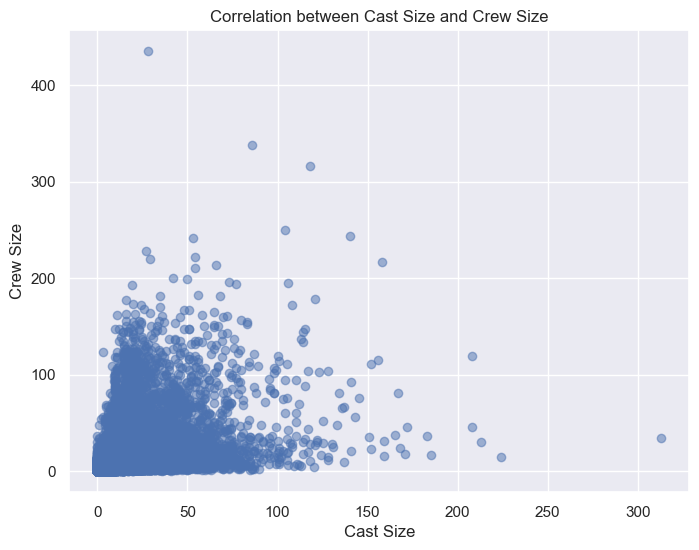

In [29]:
# Is there a correlation between the number of cast members and crew members in a movie? Visualize this relationship using a scatter plot.
valid_cast_data['cast_size'] = valid_cast_data['cast_parsed'].apply(len)
valid_crew_data['crew_size'] = valid_crew_data['crew_parsed'].apply(len)

merged_data = pd.merge(valid_cast_data, valid_crew_data, on='id', suffixes=('_cast', '_crew'))
plt.figure(figsize=(8, 6))
plt.scatter(merged_data['cast_size'], merged_data['crew_size'], alpha=0.5)
plt.title("Correlation between Cast Size and Crew Size")
plt.xlabel("Cast Size")
plt.ylabel("Crew Size")
plt.show()
